<a href="https://colab.research.google.com/github/JonssonAlexander/Detecting_Construction_pipes/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classifying images

In this notebook we will explore the task of image classification. The approach involves using a simple convolutional neural network to classify segmented images, followed by a more advanced technique that incorporates the VGG16 library into our artificial intelligence system. Through this process, we will aim to create a framework for classifying images in the construction sector. 

As you already know. We have just segmented pictures with the Segment Anything module and them stored in two different files, each containing the different labels. Now, let's take a closer look at the images.




This is sample images of the different categories that we are to classify:
1. Noise

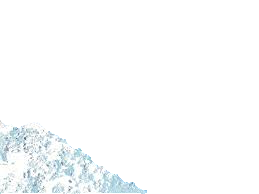 ...and yes, it is precisely as you think. This is a very vauge 
category consisting of random segments.

2. Pipes 

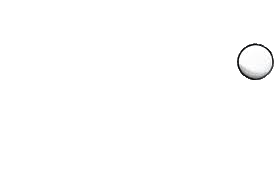

3. Pipes_2 

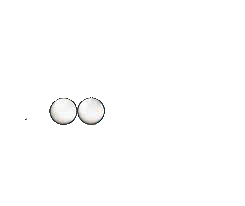...in our recieved data, we sometimes saw that Segment Anything was unable to consistantly crop out single pipes and sometimes resorted to cropping out two pipes. Therefore it would be important to put these in its own category. 

4. Pipe_holes 

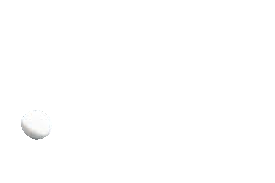... this is essentially the inside of a pipe. We might not need it when we analyse our final data but it is nontheless useful information. 

Now, let's get started.

In [ ]:
# Importing libraries 
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

The initial idea is to create four categories of data that was recognised in the labeling process: noise, pipes, two pipes (in the same image) and pipe holes. Let's try and make a simple neural network and see how it performs.  

To create the neural network, we need to put correct labels on the files from the different folders. Remember that we need both training data and test data in order to get an accurate result. 

In [ ]:
"""
Create the labels
"""

class_names = ['noise','pipe','pipe_2','pipe_holes']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# Making the image small in order to speed up the process
IMAGE_SIZE = (150, 150)

In [ ]:
def load_data():
    """
    Load the data.
    """
    datasets = ['/content/drive/MyDrive/Images_train', '/content/drive/MyDrive/Images_test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:
        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    return output

In [ ]:
# Load the data
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/Images_train


100%|██████████| 33/33 [00:14<00:00,  2.31it/s]


Loading /content/drive/MyDrive/Images_test


100%|██████████| 23/23 [00:09<00:00,  2.34it/s]


In [ ]:
# Very important to rescale our data in order to visualise it 
train_images = train_images / 255.0 
test_images = test_images / 255.0

#First AI model

We start by defining a neural network architecture to recognize images of clothing. We use Keras to create a model that has four layers: two layers that help the model to learn features from the images (called convolutional layers), two layers that help to reduce the size of the features (called max-pooling layers), a layer that flattens the features into a one-dimensional vector, a dense layer that learns to recognize patterns in the features using a mathematical function called ReLU, and a final layer that uses another mathematical function called softmax to give a probability for each type. We train this model on a large dataset of labeled images and then use it to predict the type in new images.

In [ ]:
# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

Since we only have approximately one thousand pictures, which is a relatively small amount of data, we use data agumentation to flip the images and in that way prevent overfitting. 

Normal image: 

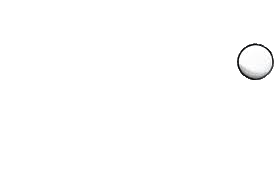

Flipped image:

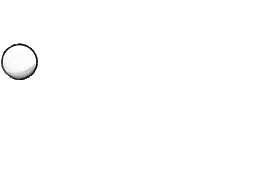


In [ ]:
# Getting more images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True)
augmented_images, augmented_labels = next(datagen.flow(train_images, train_labels, batch_size=128))
train_images = np.concatenate((train_images, augmented_images))
train_labels = np.concatenate((train_labels, augmented_labels))

In [ ]:
# Compile the model 
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the neural network
    """
    # Validate input
    if not isinstance(history, tf.keras.callbacks.History):
        raise ValueError("history must be a tf.keras.callbacks.History object")

    # Set plot style
    plt.style.use('ggplot')

    # Create figure and subplots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title("Training vs Validation Accuracy", fontsize=14)
    ax[0].set_xlabel("Epochs", fontsize=12)
    ax[0].set_ylabel("Accuracy", fontsize=12)
    ax[0].legend(loc='lower right')

    # Plot loss
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title("Training vs Validation Loss", fontsize=14)
    ax[1].set_xlabel("Epochs", fontsize=12)
    ax[1].set_ylabel("Loss", fontsize=12)
    ax[1].legend(loc='upper right')

    # Add gridlines
    ax[0].grid(True)
    ax[1].grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()


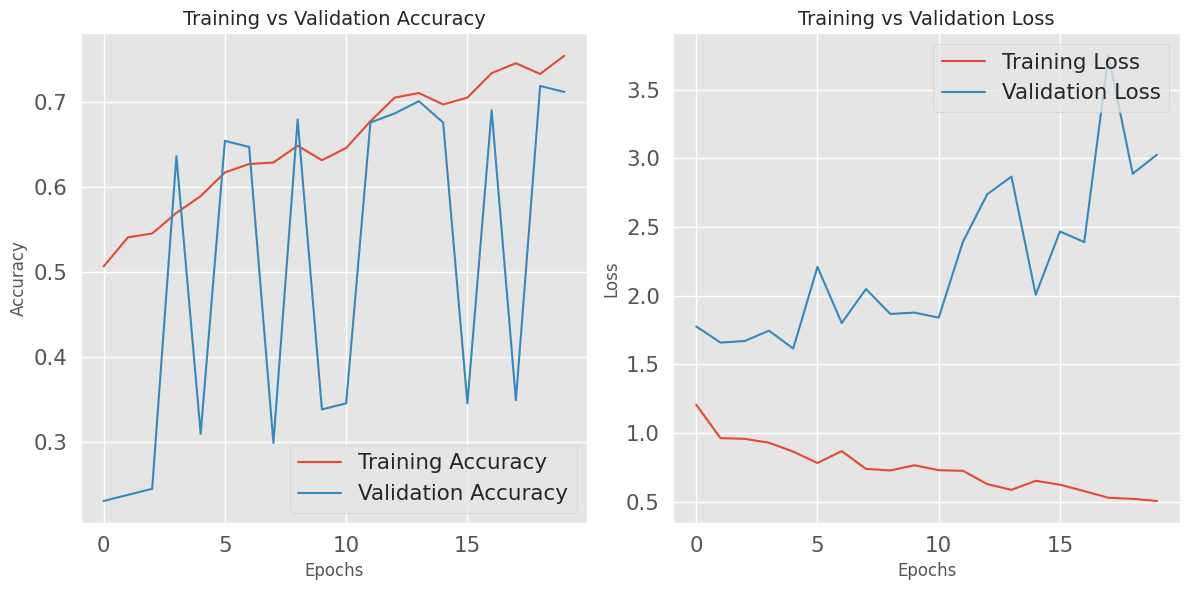

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

5/5 [==============================] - 0s 38ms/step - loss: 0.9044 - accuracy: 0.4868


In [ ]:
  def display_random_image(class_names, images, labels):
    """
    Displays a random image from the `images` array and its corresponding label from the `labels` array.
    """
    # Select a random index for the image to display
    index = np.random.randint(images.shape[0])
    
    # Display the image using matplotlib
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f"Image #{index}: {class_names[labels[index]]}")
    plt.show()

In [ ]:
def display_examples(class_names, images, labels,title,num_examples):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

5/5 [==============================] - 0s 8ms/step


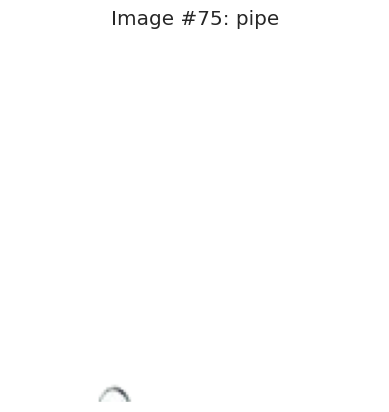

In [ ]:
# First, we make predictions on the test images using our model
predictions = model.predict(test_images) # This gives us a vector of probabilities for each image
predicted_labels = np.argmax(predictions, axis=1) # We choose the label with the highest probability

# Next, we display a random image from the test set along with its predicted label
display_random_image(class_names, test_images, predicted_labels)

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
    Print 25 examples of mislabeled images by the classifier, where test_labels do not match pred_labels.
    """
    correct_preds = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_preds == False)[0]
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names, mislabeled_images, mislabeled_labels, title=title, num_examples=25)

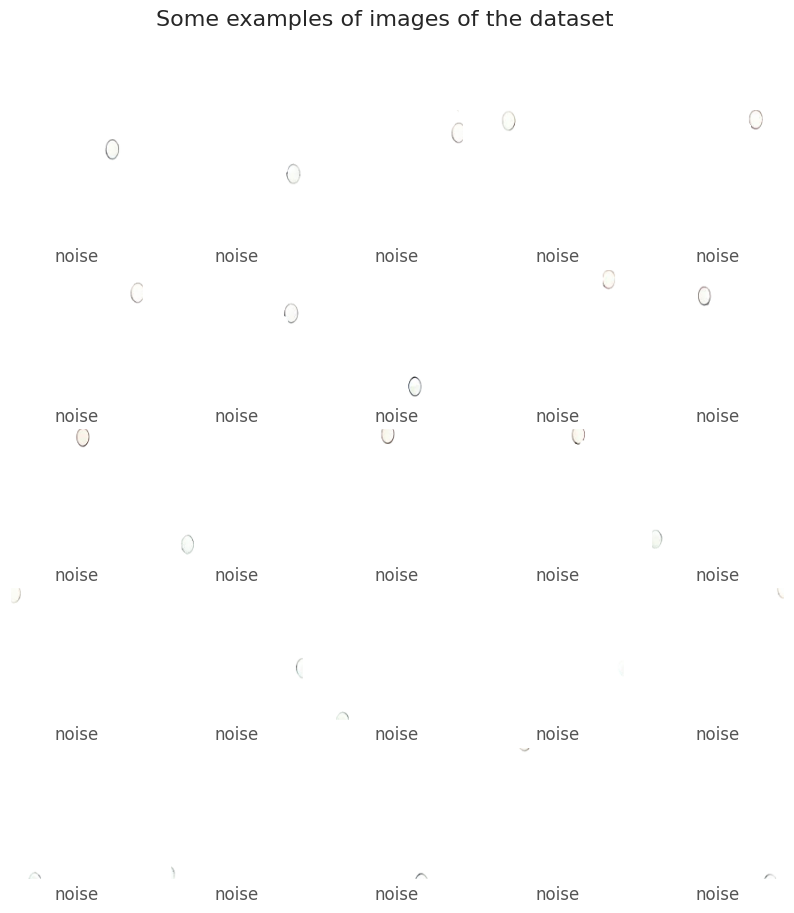

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, predicted_labels)

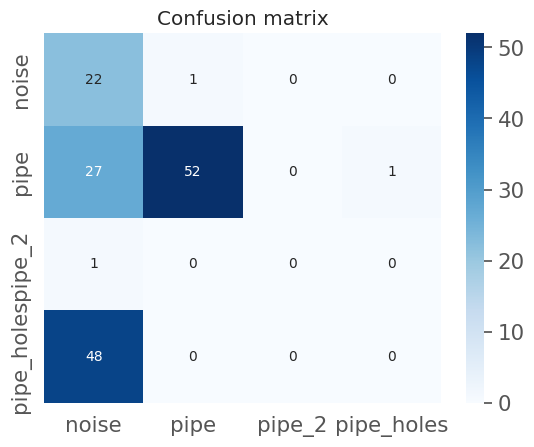

In [ ]:
# Confusion matrix to clearly display our predictions 

CM = confusion_matrix(test_labels, predicted_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax,cmap='Blues')
ax.set_title('Confusion matrix')
plt.show()

So, now we're using the VGG model to improve performance. To do this, we first import the VGG16 model and related functions from Keras. We then create a VGG16 model object with the pre-trained weights from the ImageNet dataset, excluding the top layer. By excluding the top layer of the VGG16 model, we can leverage its convolutional neural network (CNN) to extract image features, which we can then use to train a new model on top of it to improve performance on our specific task.

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False) 

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

5/5 [==============================] - 2s 500ms/step


In [ ]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

Next, we generate features from the VGG16 model for both the training and testing data. We reshape the feature vectors and perform PCA to visualize the data in 2D space. PCA is used to reduce the dimensions of a high-dimensional dataset while preserving the variability present in the data. In this case, we use PCA to visualize the data in 2D space.

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]

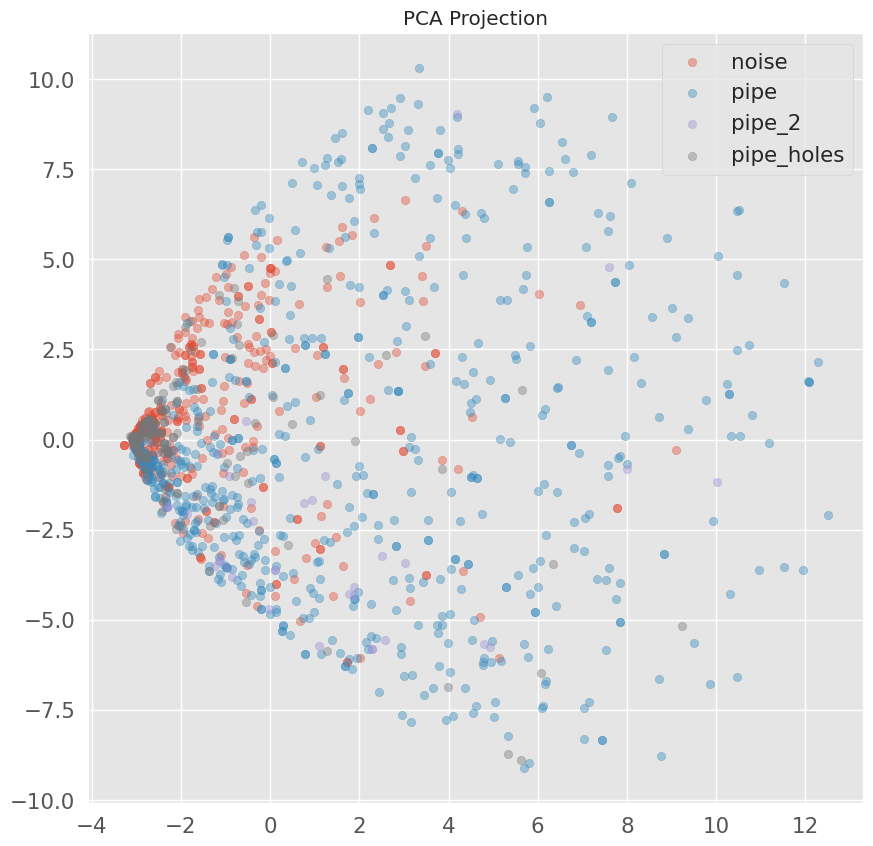

In [ ]:
import matplotlib.pyplot as plt

# Define figure size
fig, ax = plt.subplots(figsize=(10,10))

# Plot the PCA projection
for i, class_name in enumerate(class_names):
    ax.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label=class_name, alpha=0.4)

# Add legend and title
ax.legend()
ax.set_title("PCA Projection")

# Display the plot
plt.show()

In [ ]:
# Define the model 
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
9/9 [==============================] - 1s 30ms/step - loss: 1.2475 - accuracy: 0.4977 - val_loss: 1.6466 - val_accuracy: 0.2302
Epoch 2/30
9/9 [==============================] - 0s 10ms/step - loss: 0.9203 - accuracy: 0.5788 - val_loss: 1.4347 - val_accuracy: 0.6691
Epoch 3/30
9/9 [==============================] - 0s 11ms/step - loss: 0.7937 - accuracy: 0.6391 - val_loss: 1.5378 - val_accuracy: 0.6906
Epoch 4/30
9/9 [==============================] - 0s 11ms/step - loss: 0.7576 - accuracy: 0.6544 - val_loss: 1.4654 - val_accuracy: 0.7014
Epoch 5/30
9/9 [==============================] - 0s 12ms/step - loss: 0.6899 - accuracy: 0.6904 - val_loss: 1.5286 - val_accuracy: 0.7122
Epoch 6/30
9/9 [==============================] - 0s 10ms/step - loss: 0.6453 - accuracy: 0.7210 - val_loss: 1.7710 - val_accuracy: 0.6942
Epoch 7/30
9/9 [==============================] - 0s 11ms/step - loss: 0.6109 - accuracy: 0.7309 - val_loss: 1.7214 - val_accuracy: 0.7086
Epoch 8/30
9/9 [===========

We compile and train the model using the training features and labels, and evaluate its performance on the testing features and labels.

In [ ]:
# Evaluate the model on the testing data
test_loss, test_acc = model2.evaluate(test_features, test_labels)

5/5 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.6250


In [ ]:
print('Test accuracy:', test_acc)

Test accuracy: 0.625


To prevent overfitting, we also train an ensemble of models with varying sizes of dense layers, each on a random subset of the training data. We then average the predictions of all models to make the final prediction.

In [ ]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proportion of samples to use to train each estimator
max_samples = 0.8

max_samples *= len(train_features)
max_samples = int(max_samples)

# This is done in order to prevent overfitting by training each estimator on a random subset of the training data

In [ ]:
# Initialize list to store models
models = []

# Generate random layer sizes
layer_sizes = np.random.randint(50, 100, size=n_estimators)

for size in layer_sizes:
    
    # Create model with random layer size
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(x, y, z)),
        tf.keras.layers.Dense(size, activation=tf.nn.relu),
        tf.keras.layers.Dense(4, activation=tf.nn.softmax)
    ])
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Add model to list
    models.append(model)

In [ ]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size=max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split=0.1, verbose=0))

In [ ]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = np.argmax(predictions, axis=1)

5/5 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))
# Since our approach with labeling 'pipe_holes' as its own column, 56% is a good score. This clearly shows in the confusion matrix below

Accuracy: 0.5657894736842105


#Fine tuning the model

In [ ]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

5/5 [==============================] - 0s 48ms/step


In [ ]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

# Load pre-trained VGG16 model with ImageNet weights
model2 = VGG16(weights='imagenet', include_top=False)

# Get the input shape of the desired layer from VGG16
input_shape = model2.layers[-4].get_input_shape_at(0)

# Create a new input tensor to be able to feed the desired layer
layer_input = Input(shape=(9, 9, 512))

# Pass the input tensor through the desired layer of VGG16
x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)

# Add additional layers to the model
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

# Create the final model with the new input and additional layers
new_model = Model(layer_input, x)

In [ ]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
9/9 [==============================] - 1s 88ms/step - loss: 0.2333 - accuracy: 0.9046 - val_loss: 20.9020 - val_accuracy: 0.4460
Epoch 2/20
9/9 [==============================] - 1s 71ms/step - loss: 0.3025 - accuracy: 0.8731 - val_loss: 13.7721 - val_accuracy: 0.6403
Epoch 3/20
9/9 [==============================] - 1s 71ms/step - loss: 0.2269 - accuracy: 0.9127 - val_loss: 18.9619 - val_accuracy: 0.6655
Epoch 4/20
9/9 [==============================] - 1s 73ms/step - loss: 0.2189 - accuracy: 0.8938 - val_loss: 20.5747 - val_accuracy: 0.6475
Epoch 5/20
9/9 [==============================] - 1s 80ms/step - loss: 0.1892 - accuracy: 0.9253 - val_loss: 19.0184 - val_accuracy: 0.7770
Epoch 6/20
9/9 [==============================] - 1s 87ms/step - loss: 0.1570 - accuracy: 0.9307 - val_loss: 21.1379 - val_accuracy: 0.6978
Epoch 7/20
9/9 [==============================] - 1s 90ms/step - loss: 0.1497 - accuracy: 0.9379 - val_loss: 20.3523 - val_accuracy: 0.8058
Epoch 8/20
9/9 [====

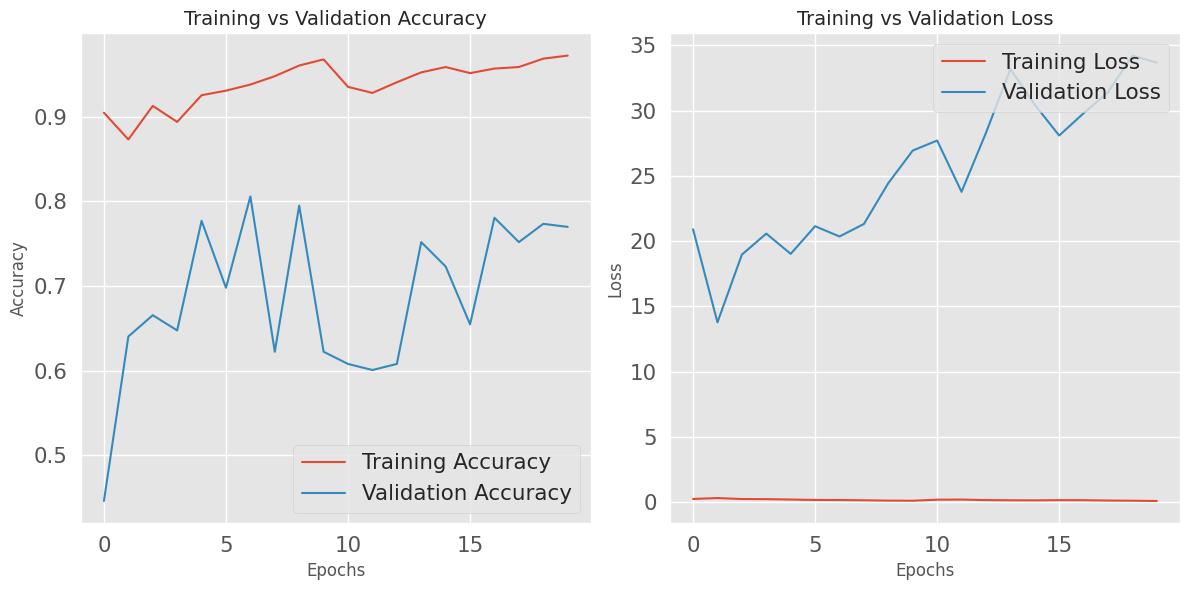

In [ ]:
plot_accuracy_loss(history)

In [ ]:
predictions = new_model.predict(test_features,verbose=0)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.75


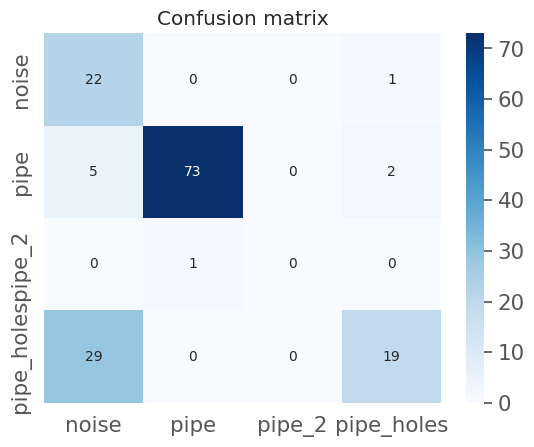

In [ ]:

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax,cmap='Blues')
ax.set_title('Confusion matrix')
plt.show()

In conclusion, we noticed that we had reduntant categories and that only two categories would be needed to create a model. Despite this, the model still performs at over 90% accuracy with only approximately 1000 segmented images. This is a major insight in the amount of data needed in order to create a powerful AI system in the construction sector. 

Special thanks to https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras and https://www.linkedin.com/pulse/segmenting-medical-images-sam-model-using-python-theodoropoulos/ as this project was heavily influenced by their work. 